# Melanoma Detection with Convolutional Neural Network

This is sample code that will ultimately be used in the Hoffman2 Linux Compute Cluster to make use of UCLA's high performance cloud computing resources like GPU requests and 64GB memory. 

Note: This sample code uses CPU only!

## Load Libraries

In [1]:
import torch
import torchvision
from torchvision.io import read_image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchvision import datasets
import numpy as np
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import resample, shuffle
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns

/Users/andrewmashhadi/opt/anaconda3/envs/pt/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Exploratory Data Analysis

General histograms and bar charts for frequencies

Proportion of positives: 0.01762965646320111


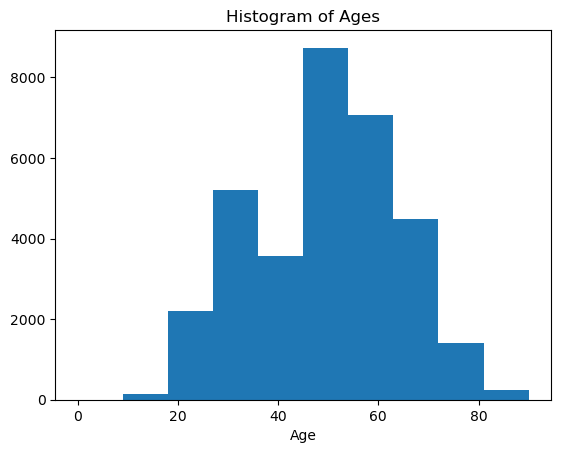

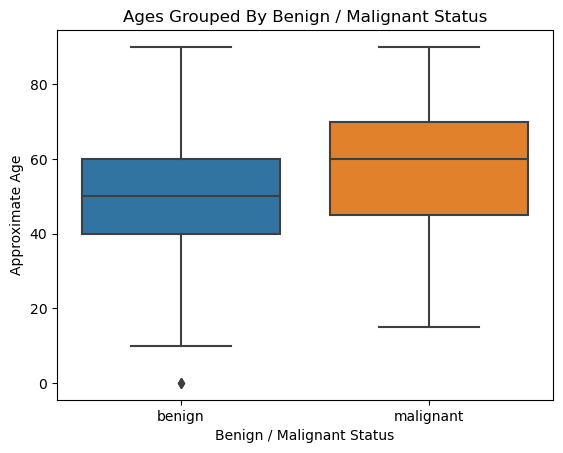

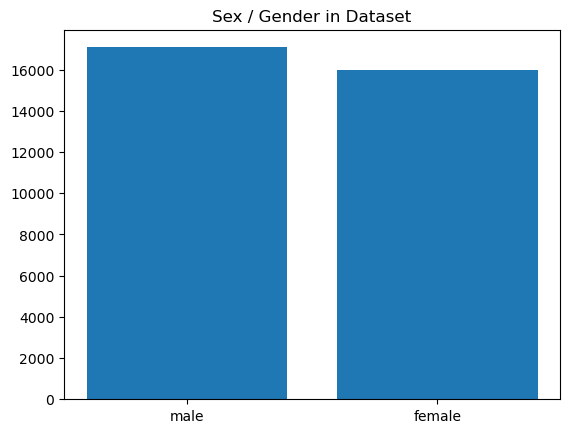

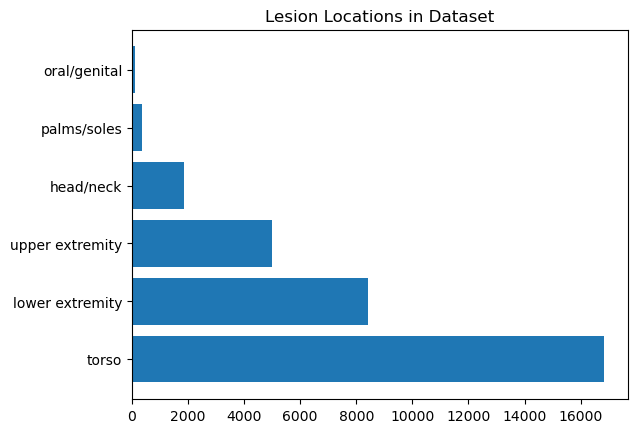

In [2]:
mel_df = pd.read_csv(os.path.join('sample_data', 'sample_data_gt.csv'))
gt = mel_df['target']
isic_id = mel_df['image_name']

# proportion of postives
print("Proportion of positives:", np.mean(gt))

plt.hist(mel_df['age_approx'])
plt.title('Histogram of Ages')
plt.xlabel('Age')
plt.show()

sns.boxplot(x = mel_df['benign_malignant'],
            y = mel_df['age_approx'])
plt.title('Ages Grouped By Benign / Malignant Status')
plt.xlabel('Benign / Malignant Status')
plt.ylabel('Approximate Age')
plt.show()


plt.bar(mel_df.sex.value_counts().index,  mel_df.sex.value_counts().values)
plt.title('Sex / Gender in Dataset')
plt.show()

plt.barh(mel_df.anatom_site_general_challenge.value_counts().index, mel_df.anatom_site_general_challenge.value_counts().values)
plt.title('Lesion Locations in Dataset')
plt.show()

Tests to find potential correlation between target variables and other categorical variables such as sex/gender or lesion location. 

******************* TARGET W/ SEX INDEPENDENCE TESTS *******************
benign_malignant  benign  malignant
sex                                
female             15761        220
male               16716        364
Chi-Squared test of independence (P-value): 2.4342390352678135e-07 



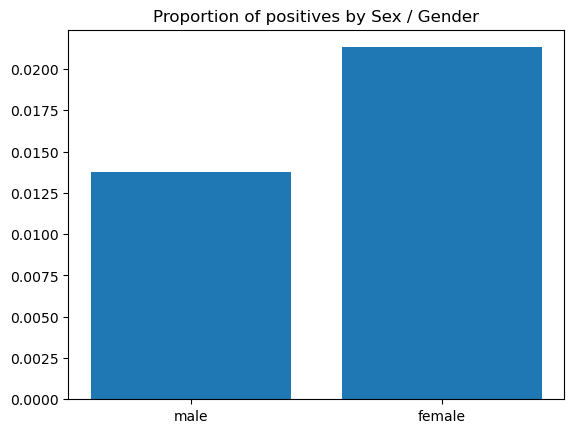



******************* TARGET W/ LESION LOCATION INDEPENDENCE TESTS *******************
anatom_site_general_challenge  head/neck  lower extremity  oral/genital  \
sex                                                                       
female                               834             4449            45   
male                                1013             3950            79   

anatom_site_general_challenge  palms/soles  torso  upper extremity  
sex                                                                 
female                                 151   7580             2687  
male                                   224   9246             2276  
Chi-Squared test of independence (P-value): 4.565901797450338e-49 



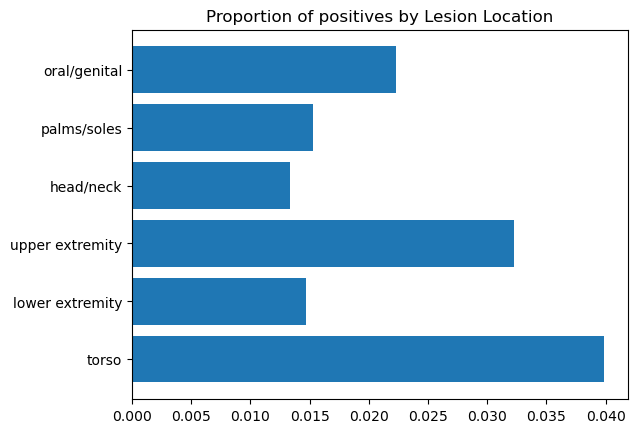

In [3]:
print("******************* TARGET W/ SEX INDEPENDENCE TESTS *******************")

data_crosstab = pd.crosstab(mel_df['sex'],
                            mel_df['benign_malignant'], 
                            margins = False)
print(data_crosstab)

chi2, p, dof, ex = ss.chi2_contingency(data_crosstab)

print("Chi-Squared test of independence (P-value):", p, "\n")

g_df1 = mel_df.groupby(['sex']).mean()
plt.bar(mel_df.sex.value_counts().index,  g_df1['target'].values)
plt.title("Proportion of positives by Sex / Gender")
plt.show()


print("\n\n******************* TARGET W/ LESION LOCATION INDEPENDENCE TESTS *******************")

data_crosstab = pd.crosstab(mel_df['sex'],
                            mel_df['anatom_site_general_challenge'], 
                            margins = False)
print(data_crosstab)

chi2, p, dof, ex = ss.chi2_contingency(data_crosstab)

print("Chi-Squared test of independence (P-value):", p, "\n")

g_df2 = mel_df.groupby(['anatom_site_general_challenge']).mean() 
plt.barh(mel_df.anatom_site_general_challenge.value_counts().index, g_df2['target'].values)
plt.title("Proportion of positives by Lesion Location")
plt.show()


## CNN Mark \#1

Set device as CPU, or GPU if available. Code will have to change if using multiple GPUs (cuda:0, cuda:1, ...).

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# If on a CUDA machine, this should print a CUDA device:
print(device)

cpu


We create a custom dataset loader class to use the ID and target information from the CSV to properly load our training and testing data.

In [5]:
# Create custom dataset to load in with the benign 
# and malignant images in the same directory
class ISICDatasetImages(Dataset):
    
    def __init__(self, img_dir, patientfile, num_samples=100, start_ind=0, up_sample=False, transform=None):
        self.img_dir = img_dir
        
        mel_df = pd.read_csv(patientfile) 
        
        if up_sample:
            
            # Separate majority and minority classes
            df_benign = mel_df[mel_df['target']==0]
            df_malignant = mel_df[mel_df['target']==1]
            

            
            
            # sample minority class
            df_benign_sampled = resample(df_benign, 
                                         replace=False,     # sample without replacement
                                         n_samples=num_samples//2,    # to have 50/50
                                         random_state=123) # reproducible results
            

            # Upsample minority class
            df_malignant_upsampled = resample(df_malignant, 
                                              replace=True,     # sample with replacement
                                              n_samples=num_samples//2,    # to have 50/50
                                              random_state=123) # reproducible results
            
            # Combine majority class with upsampled minority class
            mel_df = pd.concat([df_benign_sampled, df_malignant_upsampled])
            
            # randomly mix them up (not necessary due to shuffling in dataloader)
            mel_df = shuffle(mel_df, random_state=123) 
            
        else:
            
            self.start_ind = start_ind
            self.end_ind = start_ind+num_samples

            if self.end_ind > len(mel_df):
                self.end_ind = len(mel_df)
        
            mel_df = mel_df[self.start_ind:self.end_ind]
            
        self.gt = mel_df['target'].reset_index(drop=True)
        self.isic_id = mel_df['image_name'].reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.isic_id)
    
    def __getitem__(self, idx):
        
        img_path = os.path.join(self.img_dir, f"{self.isic_id[idx]}.jpg")
        img = read_image(img_path).float()
        class_id = torch.tensor([self.gt[idx]])
        
        if self.transform:
            img = self.transform(img)
    
        
        return img, class_id


We create a custom collate function to pad lower resolution images with zeros to maintain a constant high resolution of 3x4000x6000 for the CNN to use.

In [6]:
# helper function for padding images one at a time
def pad2d_4k6k(_image):

    rows = _image.shape[1]
    cols = _image.shape[2]

    top = np.ceil((4000 - rows)/2).astype('int')
    bottom = np.floor((4000 - rows)/2).astype('int')
    right = np.ceil((6000 - cols)/2).astype('int')
    left = np.floor((6000 - cols)/2).astype('int')

    pad_func = nn.ConstantPad2d((left, right, top, bottom), 0)
    
    return pad_func(_image)


# recall that a CNN needs the inputs to be the same dimension so we 
# custom collate function to pad small res images with 0s if they are not 3x4000x6000
def pad_collate2d(batch):
    
    # init lists
    image_list, label_list = [], []
   
    for _image, _label in batch:
    
        pad_image = pad2d_4k6k(_image)
        
        image_list.append(torch.unsqueeze(pad_image, dim=0))
        label_list.append(_label)
        

    image_out = torch.cat(image_list, dim=0) 
    label_out = torch.tensor(label_list, dtype=torch.int64)
   
    return image_out, label_out

In [7]:
testing = True

# set our batch size
batch_size = 3

transf = transforms.Compose(
    [transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = ISICDatasetImages(img_dir=os.path.join("sample_data", "sample_jpgs"), 
                            patientfile=os.path.join("sample_data", "sample_data_gt.csv"), 
                            num_samples=100, up_sample=False, start_ind=0, transform=transf)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate2d)


# test DataLoader with custom settings
if testing:
    for imgs, labels in train_loader:
        print("Batch of images has shape: ",imgs.shape)
        print("Batch of labels: ", labels)

Batch of images has shape:  torch.Size([3, 3, 4000, 6000])
Batch of labels:  tensor([0, 0, 1])
Batch of images has shape:  torch.Size([3, 3, 4000, 6000])
Batch of labels:  tensor([0, 0, 0])
Batch of images has shape:  torch.Size([3, 3, 4000, 6000])
Batch of labels:  tensor([0, 0, 0])
Batch of images has shape:  torch.Size([3, 3, 4000, 6000])
Batch of labels:  tensor([0, 0, 0])
Batch of images has shape:  torch.Size([3, 3, 4000, 6000])
Batch of labels:  tensor([0, 0, 0])
Batch of images has shape:  torch.Size([3, 3, 4000, 6000])
Batch of labels:  tensor([0, 0, 0])
Batch of images has shape:  torch.Size([3, 3, 4000, 6000])
Batch of labels:  tensor([0, 0, 0])
Batch of images has shape:  torch.Size([3, 3, 4000, 6000])
Batch of labels:  tensor([0, 0, 0])
Batch of images has shape:  torch.Size([3, 3, 4000, 6000])
Batch of labels:  tensor([0, 0, 0])
Batch of images has shape:  torch.Size([3, 3, 4000, 6000])
Batch of labels:  tensor([0, 0, 0])
Batch of images has shape:  torch.Size([3, 3, 4000

Sample and image from the data loader object to confirm it worked. Continue to run the cell for different images.

Size: torch.Size([3, 3, 4000, 6000])


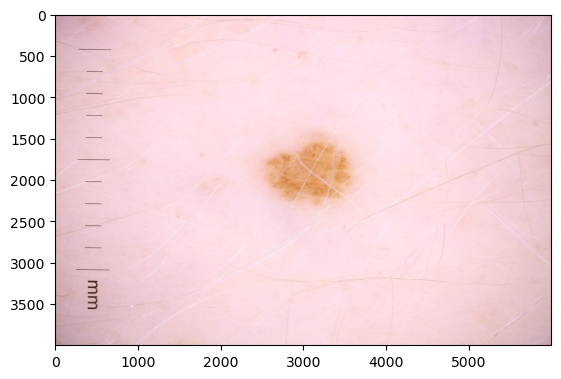

Label: Benign


In [8]:
# functions to show the image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg.astype('int'), (1, 2, 0)))
    plt.show()

label_id = ["Benign", "Malignant"]

# get some random training images
trainiter = iter(train_loader)
images, labels = trainiter.next()
print("Size:", images.shape)


# show images
imshow(images[0,])

# print labels
print("Label:", label_id[labels[0,]])

In [9]:
class Net(nn.Module):
    def __init__(self):
        '''
        torch.nn.Conv2d(in_channels, out_channels, kernel_size, 
        stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
        '''
        super().__init__()
        
        # could change this
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 15, 5)
        self.conv3 = nn.Conv2d(15, 25, 5)
        self.conv4 = nn.Conv2d(25, 40, 5)
        self.conv5 = nn.Conv2d(40, 50, 5)
        self.conv6 = nn.Conv2d(50, 60, 5)
        self.conv7 = nn.Conv2d(60, 75, 5)
        self.conv8 = nn.Conv2d(75, 85, 5)
        self.conv9 = nn.Conv2d(85, 100, 5)
        self.fc1 = nn.Linear(100*7*3, 100)  #997*1497
        self.fc2 = nn.Linear(100, 85)
        self.fc3 = nn.Linear(85, 10)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        x = self.pool(F.relu(self.conv7(x)))
        x = self.pool(F.relu(self.conv8(x)))
        x = self.pool(F.relu(self.conv9(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [ ]:
learn_weights = True
PATH = './melanoma_cnn.pth'

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    
if learn_weights:

    # set start time for cnn training
    start_time = time.time()

    for epoch in range(10):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            # print every mini-batch
            print(f'[Epoch {epoch}, Batch {i}] loss: {running_loss / (i+1)}')

    print('Finished Training', time.time() - start_time)
    
    # save the weights
    torch.save(net.state_dict(), PATH)

else:
    print('Loading the pre-trained CNN weights.')
    net.load_state_dict(torch.load(PATH))

Okay, now let us see what the convolutional neural network thinks of a few examples:

In [10]:
# Note: in the linux cluster, this is a seperate path

test_dataset = ISICDatasetImages(img_dir=os.path.join("sample_data", "sample_jpgs"), 
                            patientfile=os.path.join("sample_data", "sample_data_gt.csv"), 
                            num_samples=100, up_sample=False, start_ind=0, transform=transf)
test_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate2d)



testiter = iter(test_loader)
images, labels = testiter.next()

# print images
print('GroundTruth: ', ' '.join('%5s' % label_id[labels[j]] for j in range(batch_size)))

GroundTruth:  Benign Benign Benign


In [11]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % label_id[labels[j]] for j in range(batch_size)))

NameError: name 'net' is not defined

Now to formally test accuracy on a test set:

In [ ]:
correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network 
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total}')